**Step 1:**
Import Libraries and load the dataset

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('train.csv')

In [99]:
# drop the 'id' column
df.drop('id', axis=1, inplace=True)

In [100]:
df.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

**Step 2:**
Visualization of the dataset


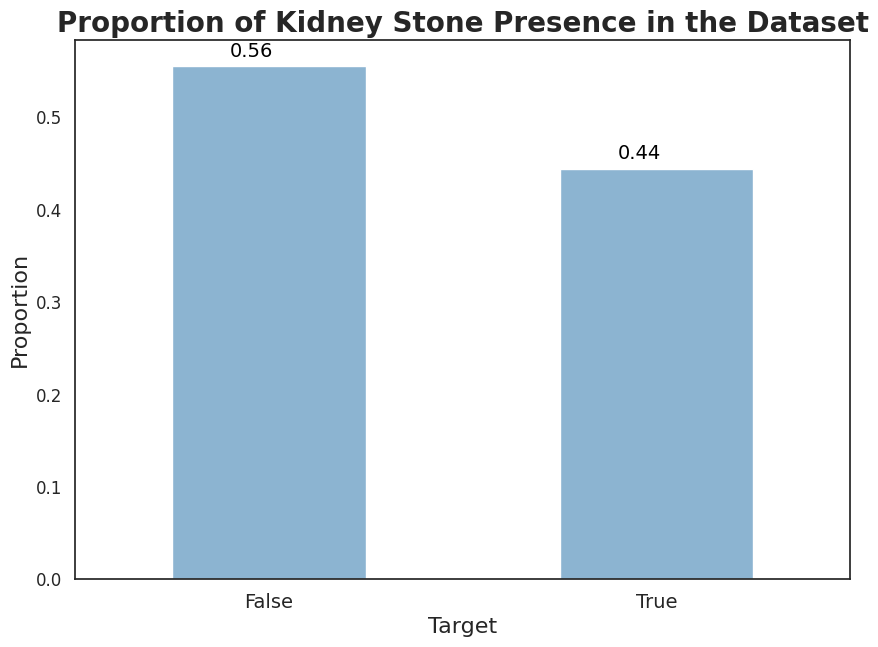

In [101]:
target_counts = df['target'].value_counts(normalize=True)

ax = target_counts.plot(kind='bar', stacked=True, figsize=(10, 7))

ax.set_xlabel('Target', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title('Proportion of Kidney Stone Presence in the Dataset', fontsize=20, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0, fontsize=14)
plt.yticks(fontsize=12)

for i, v in enumerate(target_counts):
    ax.text(i - 0.1, v + 0.01, f'{v:.2f}', fontsize=14, color='black')

plt.show()

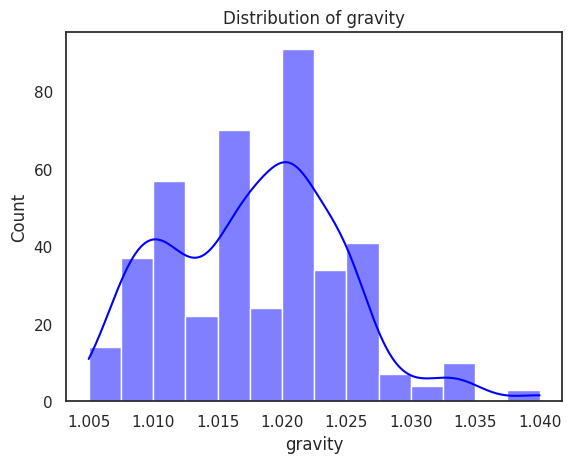

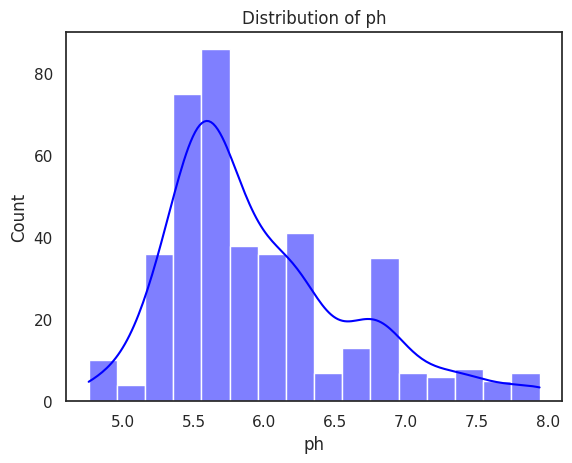

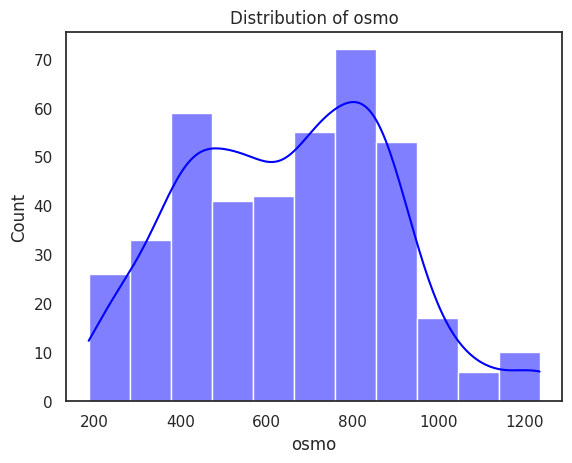

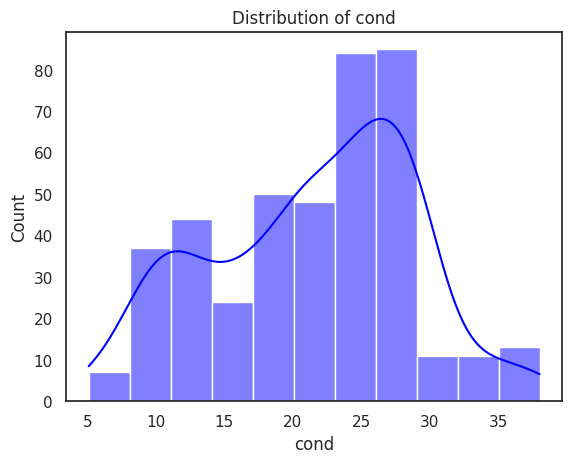

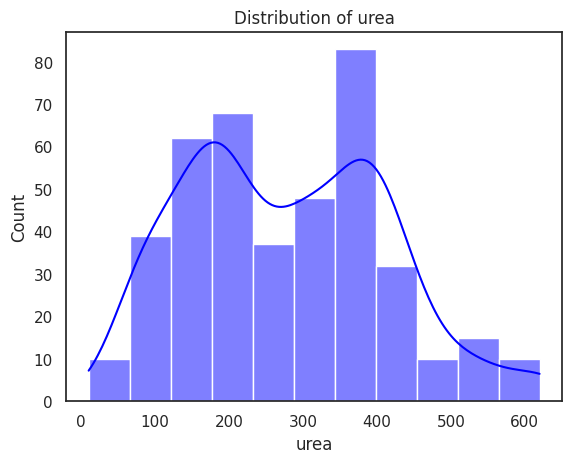

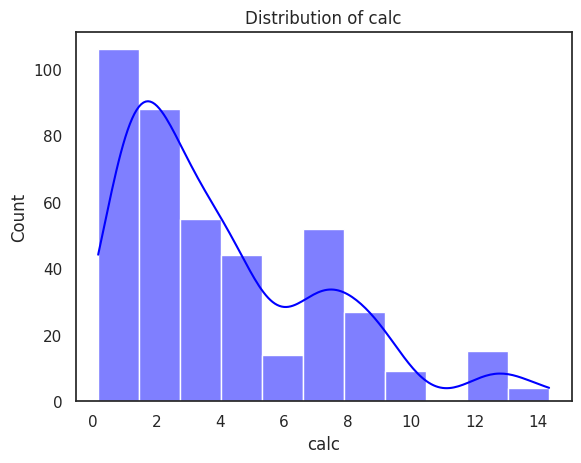

In [102]:
#Histogram distribution of the features
data_without_target = df.drop(columns=['target'])
for column in data_without_target.columns:
    plt.figure()
    sns.histplot(data=data_without_target, x=column, kde=True, color='blue')
    plt.title(f'Distribution of {column}')
    plt.show()

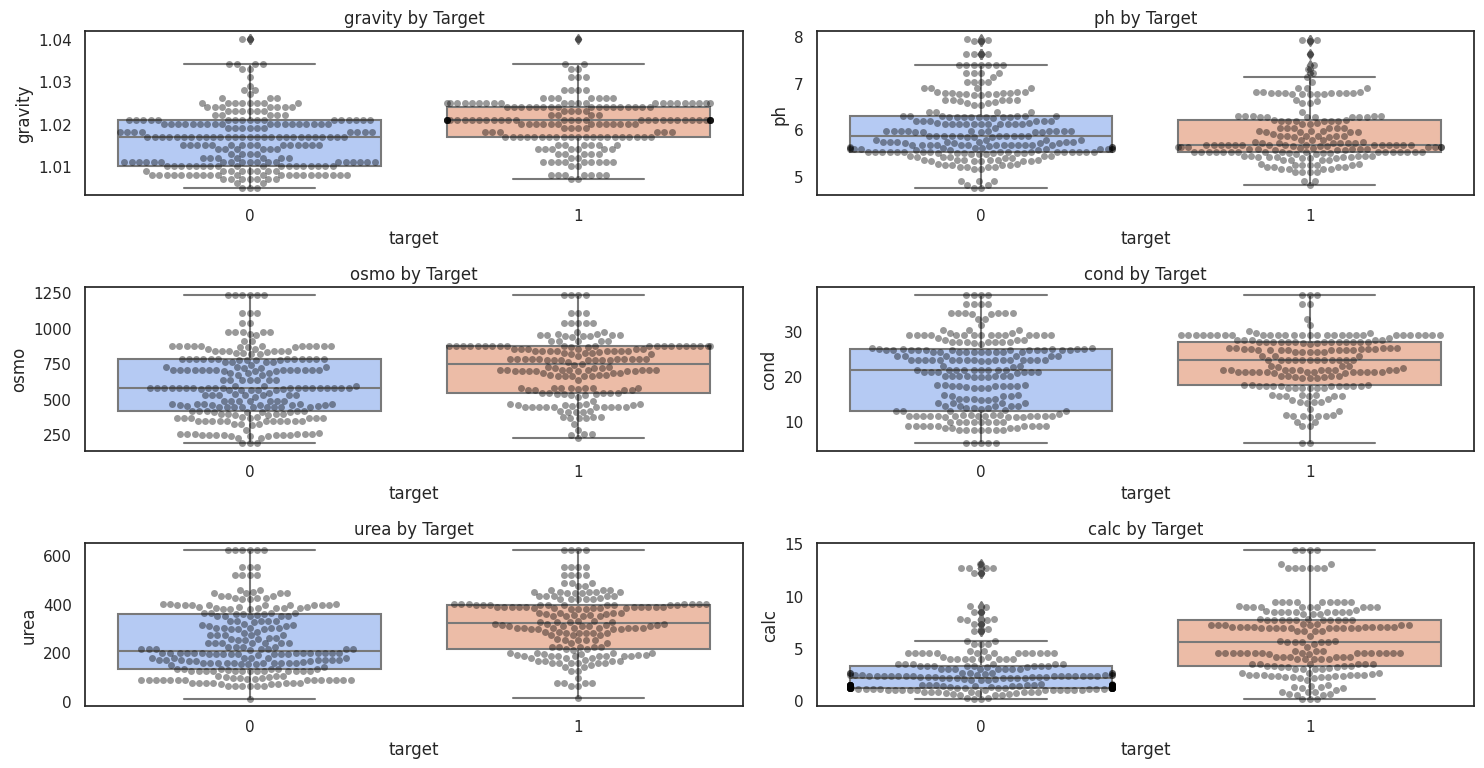

In [103]:
#Box plots and swarm plots
plt.figure(figsize=(15, 15))
for i, column in enumerate(data_without_target.columns):
    plt.subplot(len(data_without_target.columns), 2, i + 1)
    sns.boxplot(x='target', y=column, data=df, palette='coolwarm')
    sns.swarmplot(x='target', y=column, data=df, color='black', alpha=0.4)
    plt.title(f'{column} by Target')
plt.tight_layout()
plt.show()

**Step 3:**

Feature Engineering

In [104]:
#Estimated urine volume
df['urine_volume'] = (1000 * df['gravity'] * df['osmo']) / (18 * 1.001)
#Specific gravity to calcium ratio
df['specific_gravity_calcium_ratio'] = df['gravity'] / df['calc']
#Calcium to conductivity product
df['calcium_conductivity_ratio'] = df['calc'] / df['cond']
#Calcium and pH product
df['calcium_pH_interaction'] = df['calc'] * df['ph']
#Urea and pH product
df['urea_pH_interaction'] = df['urea'] * df['ph']
#Osmolarity and calcium product
df['osmolarity_calcium_interaction'] = df['osmo'] * df['calc']

Feature Importance

In [105]:
#Target variable
X = df.drop('target', axis=1)
y = df['target']
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Feature importance analysis
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

#Accuracy
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))

Accuracy: 0.5903614457831325
Classification Report:               precision    recall  f1-score   support

           0       0.62      0.64      0.63        45
           1       0.56      0.53      0.54        38

    accuracy                           0.59        83
   macro avg       0.59      0.59      0.59        83
weighted avg       0.59      0.59      0.59        83



In [106]:
#feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

                           Feature  Importance
9           calcium_pH_interaction    0.156957
11  osmolarity_calcium_interaction    0.123847
7   specific_gravity_calcium_ratio    0.120576
5                             calc    0.108591
8       calcium_conductivity_ratio    0.101252
1                               ph    0.068253
3                             cond    0.063046
10             urea_pH_interaction    0.062795
4                             urea    0.053486
0                          gravity    0.052339
6                     urine_volume    0.045024
2                             osmo    0.043837


In [107]:
#a model with fewer features is often more interpretable and reduces chances of overfitting.
num_features = 5
selected_features = feature_importance_df.nlargest(num_features, 'Importance')['Feature'].values

#New DataFrame with selected features
X_top = X[selected_features]
print(selected_features)

['calcium_pH_interaction' 'osmolarity_calcium_interaction'
 'specific_gravity_calcium_ratio' 'calc' 'calcium_conductivity_ratio']


Data Preprocessing

In [108]:
#The dataset exhibits a slight class imbalance; (False)=56% (True)=44% instances.
#This could introduce bias in the model and impact its performance.
#We can use Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class.
#This would balance the class distribution and improve the model's ability to generalize and make accurate predictions for both classes.
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X[selected_features], y)

#Use SMOTE-resampled data for training
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



Testing the accuracy of Linear Regression Models

In [109]:
#using linear regression models on this dataset
models = [
    ('LogisticRegression', LogisticRegression(max_iter=10000)),
    ('SVC', SVC()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('MLPClassifier' , MLPClassifier())
]
#calculate the accuracy for these models
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {accuracy:.4f}")

LogisticRegression accuracy: 0.7065
SVC accuracy: 0.7283
RandomForestClassifier accuracy: 0.7174
GradientBoostingClassifier accuracy: 0.7391
MLPClassifier accuracy: 0.7283


In [113]:
#Stack Analysis (Multi-Agent)

lr = LogisticRegression()
svc = SVC(probability=True)
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()
meta_model = LogisticRegression()

stacking_classifier = StackingCVClassifier(
    classifiers=[lr, svc, rf, gbc, mlp],
    meta_classifier=meta_model,
    use_probas=True,)

#Train
stacking_classifier.fit(X_train_scaled, y_train)

#Predict and calculate accuracy
y_val_pred = stacking_classifier.predict(X_val_scaled)
stacking_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Stacking Classifier accuracy: {stacking_accuracy:.4f}")

Stacking Classifier accuracy: 0.7283


Feedforward Neural Network for Binary Classification

In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

def create_nn_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
nn_model = create_nn_model(X_train_scaled.shape[1])

In [93]:
#Train
nn_history = nn_model.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
    epochs=100, batch_size=32, verbose=0
)
#Evaluate
nn_accuracy = nn_history.history['val_accuracy'][-1]
print(f"Neural Network accuracy: {nn_accuracy:.4f}")

Neural Network accuracy: 0.7717


Testing the model and predicting kidney stone presence

In [94]:
#Here we again apply feature engineering in order to run our test dataset
test_df = pd.read_csv('test.csv')

#Estimated urine volume
test_df['urine_volume'] = (1000 * test_df['gravity'] * test_df['osmo']) / (18 * 1.001)
#Specific gravity to calcium ratio
test_df['specific_gravity_calcium_ratio'] = test_df['gravity'] / test_df['calc']
#Calcium to conductivity product
test_df['calcium_conductivity_ratio'] = test_df['calc'] / test_df['cond']
#Calcium and pH product
test_df['calcium_pH_interaction'] = test_df['calc'] * test_df['ph']
#Urea and pH product
test_df['urea_pH_interaction'] = test_df['urea'] * test_df['ph']
#Osmolarity and calcium product
test_df['osmolarity_calcium_interaction'] = test_df['osmo'] * test_df['calc']

In [95]:
#Preprocessing and Scaling the test dataset
X_test = test_df[selected_features]
X_test_scaled = scaler.transform(X_test)
y_test_pred = nn_model.predict(X_test_scaled)

9/9 [==============================] - 0s 2ms/step


In [96]:
# Create a new DataFrame with ID column and predicted probabilities
result_df = pd.DataFrame({'id': test_df['id'], 'predicted_probability': y_test_pred.reshape(-1)})
result_df.head(15)

,id,predicted_probability
0,414,0.100050
1,415,0.504698
2,416,0.882806
3,417,0.549047
4,418,0.340246
5,419,0.630565
6,420,0.594691
7,421,0.907079
8,422,0.302823
9,423,0.089931


In [97]:
result_df.to_csv('Final_Predictions.csv', index=False)